# Improving `cont_cat_split` in Fastai Tabular For Homesite Competition
> Here I improve on fastai's `cont_cat_split` function and add some changes to the defaults to make another submission to Kaggle for the Homesite competition.

- toc: true 
- badges: true
- comments: true
- categories: [kaggle, fastai]
- author: Nissan Dookeran
- image: images/chart-preview.png

## Introduction

This is an additional modification of the ["first pass" submission](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/25/_First_Pass_Using_Fastai_For_Homesite_Competition.html) and subsequent [additional work](https://redditech.github.io/team-fast-tabulous/kaggle/fastai/2021/06/26/_Another_Pass_Using_Fastai_For_Homesite_Competition.html) to the Homesite Competition on Kaggle Competition using Google Colab. Modification of some of the default parameters is done with some learning from the [initial exploratory data analysis](https://redditech.github.io/team-fast-tabulous/kaggle/2021/06/23/Exploring-Homesite_Data.html) at this time, as well as other sources of readings. The major addition is listed below, but all are to see if I can improve the baseline after applying what we learnt so far to see how it improves (or not) our submission then.

Changes made:
- Use a function to better split categorical and continuous fields, and set up the categories needed for training automatically
- Included in the function is a new list `triage` which would require a manual analysis to determine a filling strategy that best suits modelling, or if to ignore the field for training
- Changed from RandomSplitter() to TrainTestSplitter() for making test and validation sets more fairly weighted based on the bias of the input data towards negative results
- Increase batch size to 1024 to make training shorter, but to still hopefully get a better predictor for it. Set a separate validator batch size to 128.
- Increase the validation percentage to 0.25
- Fix the learning rate to 1e-2
- Increase epochs to 7, see if it overfits and what effect that has
- Modified the `cat_names` and `cont_names` arrays with the initial insights from the EDA notebook post
- Add a date part for dates
- Add weight decay of 0.2

## Old stuff, read about in other notebooks

### Setup fastai and Google drive

In [1]:
!pip install -Uqq fastai

In [2]:
from fastai.tabular.all import *

The snippet below is only useful in Colab for accessing my Google Drive and is straight out the [fastbook source code in Github](https://github.com/fastai/course20/blob/master/fastbook/__init__.py) 

In [3]:
global gdrive
gdrive = Path('/content/gdrive/My Drive')
from google.colab import drive
if not gdrive.exists(): drive.mount(str(gdrive.parent))

> Only add the Kaggle bits below if I'm running locally, in Collab they're already here

In [4]:
#!pip install kaggle

In [5]:
!ls /content/gdrive/MyDrive/Kaggle/kaggle.json

/content/gdrive/MyDrive/Kaggle/kaggle.json


Useful links here:
- Documentation on [Path library](https://docs.python.org/3/library/pathlib.html#basic-use)
- Documentation on [fastai extensions to Path library](https://fastcore.fast.ai/xtras.html#Extensions-to-Pathlib.Path)

In [6]:
Path.cwd()

Path('/content')

### Setup kaggle environment parameters

In [7]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
from kaggle import api

In [9]:
path = Path.cwd()
path.ls()

(#4) [Path('/content/.config'),Path('/content/gdrive'),Path('/content/models'),Path('/content/sample_data')]

In [10]:
path = path/"gdrive/MyDrive/Kaggle/homesite_data"
path.mkdir(exist_ok=True)
Path.BASE_PATH = path
api.competition_download_cli('homesite-quote-conversion', path=path)
file_extract(path/"homesite-quote-conversion.zip")
file_extract(path/"train.csv.zip")
file_extract(path/"test.csv.zip")

homesite-quote-conversion.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
path

Path('.')

In [12]:
path.ls()

(#20) [Path('homesite-quote-conversion.zip'),Path('models'),Path('submission.csv'),Path('submission2.csv'),Path('submission3.csv'),Path('submission4.csv'),Path('submission5.csv'),Path('submission6.csv'),Path('submission7.csv'),Path('submission8.csv')...]

### Exploring the Homesite data

Set the random seed so that the results are reproducible, set other parameters so changes can be made quickly. Trying to avoid ['magic numbers'](https://en.wikipedia.org/wiki/Magic_number_(programming)) where possible

In [13]:
set_seed(42) 
bs = 1024
val_bs = 128
test_size = 0.25
epochs = 5
lr = 0.0012
wd=0.2

In [14]:
df_train = pd.read_csv(path/"train.csv", low_memory=False)
df_train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,17,23,17,23,15,22,16,22,13,22,13,23,T,D,2,1,7,18,3,8,0,5,5,24,V,48649,0,0,0,0,...,8,4,20,22,10,8,6,5,15,13,19,18,16,14,21,23,21,23,16,11,22,24,7,14,-1,17,15,17,14,18,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,6,8,6,8,5,7,5,8,13,22,13,23,T,E,5,9,5,14,6,18,1,5,5,11,P,26778,0,0,1,1,...,23,24,11,15,21,24,6,11,21,21,18,15,20,20,13,12,12,12,15,9,13,11,11,20,-1,9,18,21,8,7,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,7,12,7,12,6,10,7,11,25,25,13,23,T,J,4,6,3,10,4,11,1,5,5,11,K,8751,0,0,2,2,...,21,22,24,25,20,22,7,13,23,23,20,19,20,20,18,20,19,21,20,19,11,8,3,3,-1,5,21,24,12,15,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,3,2,3,2,2,2,3,2,13,22,13,23,Y,F,15,23,8,19,14,24,0,5,5,23,V,43854,0,0,0,0,...,3,1,14,22,6,2,7,14,11,8,19,18,18,16,13,12,13,12,17,13,5,2,3,4,-1,7,14,14,14,18,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,8,13,8,13,7,11,7,13,13,22,13,23,T,F,4,6,3,6,3,6,1,5,5,7,R,12505,1,0,0,0,...,24,25,9,11,25,25,5,3,22,22,21,21,17,15,25,25,25,25,17,13,13,11,3,4,-1,7,11,9,10,10,18,22,-1,10,-1,11,-1,12,N,IL


In [15]:
df_train.shape

(260753, 299)

In [16]:
df_test = pd.read_csv(path/"test.csv", low_memory=False)
df_test.head()

,QuoteNumber,Original_Quote_Date,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,0.9364,0.0006,"1,487",1.3045,N,4,4,4,4,3,3,3,4,13,22,13,23,Y,K,13,22,6,16,9,21,0,5,5,11,P,67052,0,0,0,0,0,...,22,23,9,12,25,25,6,9,4,2,16,12,20,20,2,2,2,1,1,1,10,7,25,25,-1,19,19,22,12,15,1,1,-1,1,-1,20,-1,25,Y,IL
1,5,2013-09-07,F,11,0.9919,0.0038,564,1.1886,N,8,14,8,14,7,12,8,13,13,22,13,23,T,E,4,5,3,6,3,6,1,5,5,4,R,27288,1,0,0,0,0,...,23,24,12,21,23,25,7,11,16,14,13,6,17,15,7,5,7,5,13,7,14,14,7,14,-1,4,1,1,5,3,10,10,-1,5,-1,5,-1,21,N,NJ
2,7,2013-03-29,F,15,0.8945,0.0038,564,1.0670,N,11,18,11,18,10,16,10,18,13,22,13,23,T,E,3,3,5,14,3,9,1,5,5,23,V,65264,0,1,2,2,0,...,16,18,9,10,14,16,6,8,20,19,17,14,16,13,20,22,20,22,20,18,10,7,4,7,-1,11,13,12,18,22,10,11,-1,20,-1,22,-1,11,N,NJ
3,9,2015-03-21,K,21,0.8870,0.0004,"1,113",1.2665,Y,14,22,15,22,13,20,22,25,13,22,13,23,Y,F,5,9,9,20,5,16,1,5,5,11,R,32725,1,1,1,1,0,...,11,11,9,10,11,13,15,21,14,12,17,13,10,6,20,22,20,22,19,16,12,11,4,6,-1,13,10,8,5,3,8,8,-1,13,-1,8,-1,21,N,TX
4,10,2014-12-10,B,25,0.9153,0.0007,935,1.0200,N,4,5,4,5,4,4,4,5,13,22,13,23,Y,D,12,21,1,1,3,6,0,5,5,11,T,56025,0,1,1,1,0,...,9,8,25,25,9,3,9,18,7,4,16,12,13,9,8,6,8,6,11,5,19,21,13,21,-1,23,11,8,5,3,7,7,-1,3,-1,22,-1,21,N,CA


In [17]:
df_test.shape

(173836, 298)

In [18]:
y_column = df_train.columns.difference(df_test.columns)

In [19]:
y_column

Index(['QuoteConversion_Flag'], dtype='object')

From this it looks like `QuoteConversion_Flag` is the value we want to predict. Let's take a look at this

In [20]:
type(df_train.QuoteConversion_Flag)

pandas.core.series.Series

In [21]:
df_train.QuoteConversion_Flag.unique()

array([0, 1])

In [22]:
type(df_train.QuoteConversion_Flag.unique()[0])

numpy.int64

Make this a boolean for the purpose of generating predictions as a binary classification

In [23]:
df_train.QuoteConversion_Flag = df_train.QuoteConversion_Flag.astype(dtype='boolean')

Let's see how the training data outcomes are balanced

In [24]:
df_train.QuoteConversion_Flag.describe()

count     260753
unique         2
top        False
freq      211859
Name: QuoteConversion_Flag, dtype: object

In [25]:
train_data_balance = pd.DataFrame(df_train["QuoteConversion_Flag"]).groupby("QuoteConversion_Flag")

In [26]:
train_data_balance["QuoteConversion_Flag"].describe()

,count,unique,top,freq
QuoteConversion_Flag,,,,
False,211859,1,False,211859
True,48894,1,True,48894


We have about 5 times as many "No Sale" data rows as we do data that shows a successful sale happened. This *data bias* may have an impact on the effectiveness of our model to predict positive sales results

### First things first 
Learning from [my colleague Tim's work](https://redditech.github.io/team-fast-tabulous/jupyter/2021/06/20/Identify-problem-type.html) already we know:
- `Quotenumber` is unique so we can make it the index
- `Original_Quote_Date` column should be set as a date type

Additionally, we should make sure to apply any changes to data types to both train and test data so predictions don't fail later on


In [27]:
df_train = df_train.set_index('QuoteNumber')
df_test = df_test.set_index('QuoteNumber')

We may have some NaN values for Original_Quote_Date in either the training or test dataset, but let's confirm there are none.

In [28]:
df_train['Original_Quote_Date'].isna().sum(), df_test['Original_Quote_Date'].isna().sum()

(0, 0)

In [29]:
df_train['Original_Quote_Date'] = pd.to_datetime(df_train['Original_Quote_Date'])
df_test['Original_Quote_Date'] = pd.to_datetime(df_test['Original_Quote_Date'])

Add the date_part to see if this helps improve modeling

In [30]:
df_train = add_datepart(df_train, 'Original_Quote_Date')
df_test = add_datepart(df_test, 'Original_Quote_Date')

## Goal: Automate the bits we can, continue refining fastai parameters, continue using EDA insights gathered to date

In [31]:
y_names = [y_column[0]]
y_names

['QuoteConversion_Flag']

In [32]:
cont_names, cat_names = cont_cat_split(df_train, dep_var=y_names)
len(cont_names), len(cat_names)

(155, 154)

In [33]:
# df_train.drop('PropertyField29', axis=1, inplace=True)
# df_train.drop('PersonalField84', axis=1, inplace=True)

### New Work - A function to improve fastai's `cont_cat_split` choices

First I'll create a `triage` list for any fields that can't be programmatically optimized. These are the ones we have to do manual steps for until I find a way to do better

In [34]:
triage = L()

Let's take a quick look at the descriptions of the categorical and continuous splits automatically done

In [35]:
df_train[cont_names].astype('object').describe()

,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,...,GeographicField42B,GeographicField43A,GeographicField43B,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60B,GeographicField61B,Original_Quote_Week,Original_Quote_Day,Original_Quote_Dayofyear,Original_Quote_Elapsed
count,260753,260753.0000,260753.0000,260753.00,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,136545.0,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753.0,260753,260753,...,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,2.607530e+05
unique,28,38.0000,5.0000,11.00,26,26,25,25,25,25,25,25,26,26,25,25,26,26,24,61530,22,26,26,26,26,30,22,7.0,26,26,21,26,26,26,26,26,26,11.0,26,26,...,26,26,26,26,26,26,26,26,26,26,25,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,26,25,26,26,26,26,26,26,26,25,52,31,365,8.680000e+02
top,23,0.9403,0.0006,1.02,6,9,6,7,5,9,6,4,4,15,3,5,3,1,11,36088,0,-1,-1,-1,-1,2,24,2.0,4,20,15,3,1,6,3,7,4,1.0,9,10,...,21,11,5,9,22,11,4,10,7,6,5,19,8,18,25,17,23,14,25,14,17,20,25,15,2,4,9,2,13,19,11,1,11,6,18,2,11,3,70,1.393805e+09
freq,66474,48161.0000,74096.0000,92359.00,24736,11089,25026,11137,23663,10881,24614,10756,28378,10923,50250,10581,59953,10487,89335,19,167612,24526,24526,54785,54785,85608,124015,134906.0,23038,12620,22598,30574,10571,24336,10548,20522,11055,121563.0,20538,11664,...,10547,41899,10553,32537,10552,51208,10595,64704,10670,76413,18736,15213,10760,21011,10547,18093,10525,17007,10472,16667,10517,21298,10501,17134,10487,28655,10545,20725,22086,10625,19660,10570,17608,11216,10583,20717,7523,9314,1502,6.460000e+02


The first thing I notice, is that for a number of these fields, there is quite a low number of `unique` values. I also notice some, like `PersonalField84` are missing quite a bit of data. These are a lot of fields to go through and manually recategorize and then get their categories, but I am hoping I can do this programmatically.

Let's have a look at the existing categoricals to make sure there's nothing suspeicious about these here either

In [36]:
df_train[cat_names].astype('object').describe()

,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,...,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start
count,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260640,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,...,260753,260753,260753,260753,260753,260753,260683,260753,260683,260753,260640,260753,259533,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753,260753
unique,8,8,2,3,4,3,4,7,12,2,5,5,7,2,19,20,8,12,12,2,2,9,2,2,3,3,5,5,4,50,66,61,57,7,13,14,14,14,17,7,...,5,13,17,4,2,4,2,4,2,3,2,2,2,2,14,1,2,2,20,2,2,2,12,2,2,2,2,2,19,3,4,3,12,7,2,2,2,2,2,2
top,B,935,N,13,22,13,23,Y,E,1,5,5,K,0,0,0,0,0,0,1,1,7,0,N,1,2,0,1,2,ZA,ZE,XR,XD,1,0,0,0,0,1,1,...,2,1,4,B,N,O,Y,H,Y,2,N,N,N,-1,13,-1,25,-1,7,-1,-1,-1,15,-1,-1,-1,-1,-1,8,N,CA,2014,3,0,False,False,False,False,False,False
freq,94694,52353,241867,212390,212390,170589,170589,143152,85017,194250,158481,147571,50261,222421,200758,170439,246479,240315,239868,189441,182307,164202,164202,259379,260715,190879,254940,160257,258621,124015,124015,124015,124015,254447,256107,255215,254447,253407,129036,134167,...,259655,205119,92797,243374,245807,156042,191627,123098,141185,166293,248302,185976,254032,254208,135320,260753,260751,253814,71697,254135,254285,254158,156405,254096,254153,254239,254170,254144,83404,254712,94725,110107,31742,49924,252323,252730,257614,257381,260240,260404


So there may be some fields with missing data here, like `PropertyField38` we will have to look at a strategy for these too

> Question for later: Should those with only two categories be mapped as Categorical or Booleans? Would there be any impact here? See an example field below

In [37]:
field = "Field12"
df_train[field].unique()

array(['N', 'Y'], dtype=object)

Here I define two functions, which will help 
- to reset the `cont_names` and `cat_names` arrays with better fits of the actual data fields for those that are categorical, but were put into the continuous array. 
- For all cateogircal fields, it will also setup the categories for these fields and change their dtype 
- For any fields that have null values, it will remove them from their respective field, and place them in the `triage` list

In [38]:
def reassign_to_categorical(field, df, continuous, categorical, triage):
  if df[field].isna().sum()==0:
    field_categories = df[field].unique()
    df[field] = df[field].astype('category')
    df[field].cat.set_categories(field_categories, inplace=True)
    if field in continuous: continuous.remove(field)
    if field not in categorical: categorical.append(field)
  else:
    if field in continuous: continuous.remove(field)
    if field in categorical: categorical.remove(field)
    triage.append(field)

  return df, continuous, categorical, triage

In [39]:
def categorize( df, cont_names, cat_names, triage, category_threshold):
  for field in df.columns:
    if ((len(df[field].unique()) <= category_threshold) and (type(df[field].dtype) != pd.core.dtypes.dtypes.CategoricalDtype)):
      reassign_to_categorical(field, df, cont_names, cat_names, triage)
  return df, cont_names, cat_names, triage

In [40]:
field = 'Field8'
df_train[field].unique()

array([0.9403, 1.0006, 0.9769, 0.9472, 0.9258, 0.9153, 0.9691, 0.9919,
       0.9497, 0.9893, 0.8793, 0.9485, 0.8922, 1.0101, 0.893 , 0.9219,
       0.9392, 0.9685, 0.887 , 0.8746, 0.8928, 0.9838, 1.0005, 0.9487,
       0.9313, 0.9525, 0.9559, 0.9482, 0.9223, 0.9566, 0.9108, 0.8945,
       0.9023, 0.9489, 0.9194, 0.9364, 0.9368, 0.9375])

In [41]:
df_train, cont_names, cat_names, triage = categorize(df_train, cont_names, cat_names, triage, 100)

In [42]:
len(cont_names), len(cat_names)

(3, 298)

So this is a big rebalancing between continuous and categorical fields. I saved alot of time with this function rather than doing this manually like I had for my initial data exploration. Let's take a look at how many came up for triaging still though

In [43]:
triage

(#9) ['PersonalField7','PersonalField84','PropertyField3','PropertyField4','PropertyField29','PropertyField32','PropertyField34','PropertyField36','PropertyField38']

And let's look again at `Field8` to see how it did the categorizations for me

In [44]:
field = 'Field8'
df_train[field].unique()

[0.9403, 1.0006, 0.9769, 0.9472, 0.9258, ..., 0.9489, 0.9194, 0.9364, 0.9368, 0.9375]
Length: 38
Categories (38, float64): [0.9403, 1.0006, 0.9769, 0.9472, ..., 0.9194, 0.9364, 0.9368, 0.9375]

ToDo: Put in bits that triage those 9 fields that popped up. For now I will run the modelling ignoring these fields and see if any improvements happen.

#### Triaging

In [45]:
triage

(#9) ['PersonalField7','PersonalField84','PropertyField3','PropertyField4','PropertyField29','PropertyField32','PropertyField34','PropertyField36','PropertyField38']

##### PersonalField7

In [46]:
field = 'PersonalField7'
True in df_train[field].isna()

True

In [47]:
df_train[field].value_counts()

N    259379
Y      1261
Name: PersonalField7, dtype: int64

### Back to the training pipeline I had originally

In [48]:
### Back to old stuff

In [49]:
"QuoteConversion_Flag" in cont_names, "QuoteConversion_Flag" in cat_names #Make sure we've gotten our y-column excluded

(False, True)

In [50]:
if (y_column in cont_names): cont_names.remove(y_column)
if (y_column in cat_names): cat_names.remove(y_column)

In [51]:
procs = [Categorify, FillMissing, Normalize]
splits = TrainTestSplitter(test_size=test_size, stratify=df_train[y_names])(df_train)

In [52]:
to = TabularPandas(df=df_train, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=y_names,splits=splits)
dls = to.dataloaders(bs=bs, val_bs=val_bs)
dls.valid.show_batch()


,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField33,PropertyField35,PropertyField37,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,Original_Quote_Year,Original_Quote_Month,Original_Quote_Dayofweek,Original_Quote_Is_month_end,Original_Quote_Is_month_start,Original_Quote_Is_quarter_end,Original_Quote_Is_quarter_start,Original_Quote_Is_year_end,Original_Quote_Is_year_start,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32

In [53]:
len(dls.train)*bs, len(dls.valid)*val_bs

(194560, 65280)

In [54]:
roc_auc_binary = RocAucBinary()
learn = tabular_learner(dls, metrics=roc_auc_binary)

In [55]:
type(roc_auc_binary)

fastai.metrics.AccumMetric

SuggestedLRs(valley=tensor(0.0006))

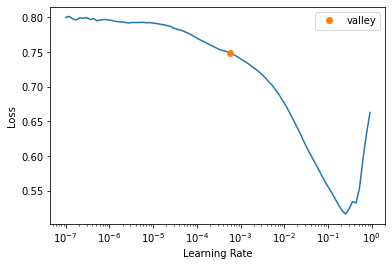

In [56]:
learn.lr_find()

[Reference to why we use fit_one_cycle](https://fastai1.fast.ai/callbacks.one_cycle.html)

> Note I ran `fit_one_cycle` with a value of 10 when prepping this notebook for publishing, but the test results came out suspiciously high on `1` outputs, given that the test submission I ran before was heavily weighted with `0` outputs and got a 0.83 score when I ran with `5` but I didn't set the random seed value then. What happened I think was changing the splitter, I got a different tensor output and I was looking at the alternate value column instead column with the prediction value.

In [57]:
learn.fit_one_cycle(epochs, lr, wd=wd)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.279747,0.202921,0.954094,01:45
1,0.188010,0.182800,0.960526,01:46
2,0.170447,0.182175,0.960804,01:51
3,0.147315,0.189143,0.958946,01:48
4,0.112068,0.201419,0.956670,01:46


Referenced another [Kaggle notebook](https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble?scriptVersionId=12269139) for this, we don't need it but it's good to see what fastai metrics is actually packaging up for you

In [58]:
preds, targs = learn.get_preds()


In [59]:
preds[0:1][0][0], preds[0:1][0][1]

(tensor(0.9987), tensor(0.0013))

Here was my mistake, I was looking at the wrong classifier value

In [60]:
len(preds)

65189

In [61]:
(preds[:][:][:,1] >= 0.5).sum(), (preds[:][:][:,1] < 0.5).sum()

(tensor(10698), tensor(54491))

In [62]:
from sklearn.metrics import roc_auc_score
valid_score = roc_auc_score(to_np(targs), to_np(preds[:][:][:,1]))
valid_score

0.9566703126953837

Doing inferences based on this [blog post](https://walkwithfastai.com/tab.clas.binary) from Walk With Fastai initially, but then experimenting to get this

In [63]:
dl_test = dls.test_dl(df_test)

In [64]:
preds, _ = learn.get_preds(dl=dl_test)

In [65]:
(preds[:][:][:,1] >= 0.5).sum(), (preds[:][:][:,1] < 0.5).sum()

(tensor(28902), tensor(144934))

## Submission To Kaggle

In [66]:
path.ls()

(#20) [Path('homesite-quote-conversion.zip'),Path('models'),Path('submission.csv'),Path('submission2.csv'),Path('submission3.csv'),Path('submission4.csv'),Path('submission5.csv'),Path('submission6.csv'),Path('submission7.csv'),Path('submission8.csv')...]

In [67]:
len(df_test.index), len(preds[:][:][:,1])

(173836, 173836)

In [68]:
preds[:1][:1]

tensor([[0.9976, 0.0024]])

We want the 2nd value, this is what gives us our prediction value of how likely our model thinks this is going to be a sale

In [69]:
preds[:1][:1][:,1]

tensor([0.0024])

In [70]:
submission = pd.DataFrame({'QuoteNumber': df_test.index, 'QuoteConversion_Flag': preds[:][:][:,1].tolist()}, columns=['QuoteNumber', 'QuoteConversion_Flag'])


Played around with the example on list comprehension [here](https://www.kite.com/python/answers/how-to-convert-a-list-of-integers-into-a-single-integer-in-python) to get it to work with what I had to work with

In [71]:
submission.QuoteConversion_Flag = [float(qcf) for qcf in submission.QuoteConversion_Flag]

In [72]:
submission.head()

,QuoteNumber,QuoteConversion_Flag
0,3,0.002424
1,5,0.012709
2,7,0.005221
3,9,0.001084
4,10,0.571628


In [73]:
submission.QuoteConversion_Flag = round(submission.QuoteConversion_Flag).astype('Int64')

In [74]:
submission.head()

,QuoteNumber,QuoteConversion_Flag
0,3,0
1,5,0
2,7,0
3,9,0
4,10,1


In [75]:
len(submission[submission.QuoteConversion_Flag==1])

28902

In [76]:
len(submission[submission.QuoteConversion_Flag==0])

144934

In [77]:
submission.to_csv(path/'submission13.csv', index=False)

In [78]:
api.competition_submit(path/'submission13.csv',message="Thirteenth pass", competition='homesite-quote-conversion')

100%|██████████| 1.45M/1.45M [00:00<00:00, 7.07MB/s]


Successfully submitted to Homesite Quote Conversion

In [79]:
learn.save('homesite_fastai_nn13')

Path('models/homesite_fastai_nn13.pth')